In [99]:
import json, glob, os, random
from math import log as ln
import cv2
import numpy as np
import visualization as vis

def IOU(xminA, yminA, xmaxA, ymaxA, xminB, yminB, xmaxB, ymaxB): # VOC
    inter = max(0,min(ymaxA,ymaxB)-max(yminA,yminB)) * max(0,min(xmaxA,xmaxB)-max(xminA,xminB))
    areaA = (ymaxA-yminA) * (xmaxA-xminA)
    areaB = (ymaxB-yminB) * (xmaxB-xminB)
    return inter / (areaA+areaB-inter) if (areaA+areaB-inter)!=0 else 0

def entropy(p):
    return - p*ln(p) - (1-p)*ln(1-p)

def symmetricKL(p, q):
    return 0.5*( p*ln(p/q) + (1-p)*ln((1-p)/(1-q)) + q*ln(q/p) + (1-q)*ln((1-q)/(1-p)) )

class ActiveLearning:
    """
    obj = ActiveLearning("/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14", "../runs/test/unlabeled0614_v0_raw/best_1365_predictions.json", \
                     "../runs/test/unlabeled0614_v0_flip/best_1365_predictions.json", 0.08, ['tetra'], "../_data/psuedoV0")
    obj.visPredict("random")
    obj.matching()
    obj.score()
    obj.visPredict("acq")
    obj.generate()
    obj.visPseudo("hard")
    obj.visPseudo("easy")
    """
    def __init__(self, imgFolder, rawJsonPath, flipJsonPath, threshold, classL, outputPath):
        self.imgFolder = imgFolder
        self.height, self.width, _ = cv2.imread( glob.glob(imgFolder+"/*.jpg")[0] ).shape # 720*1280
        self.D = { os.path.abspath(imgPath):{"r":[],"f":[]} for imgPath in glob.glob(imgFolder+"/*.jpg") }
        self.loadJson(rawJsonPath, flipJsonPath)
        print( f"self.height={self.height}, self.width={self.width}, len(self.D)={len(self.D)}" )
        print( f"self.D[list(self.D)[0]] = {self.D[list(self.D)[0]]}" )
        self.threshold = threshold
        self.classL = classL
        self.outputPath = outputPath
        
    def loadJson(self, rawJsonPath, flipJsonPath):
        for di in json.load(open(rawJsonPath,"r")):
            imgPath = os.path.abspath( f"{self.imgFolder}/{di['image_id']}.jpg" )
            xmin, ymin, w, h = di['bbox']
            self.D[imgPath]['r'].append( [di['category_id']-1, di['score'], xmin, ymin, xmin+w, ymin+h] )
        for di in json.load(open(flipJsonPath,"r")):
            imgPath = os.path.abspath( f"{self.imgFolder}/{di['image_id']}.jpg" )
            xmin, ymin, w, h = di['bbox']
            self.D[imgPath]['f'].append( [di['category_id']-1, di['score'], self.width-xmin-w, ymin, self.width-xmin, ymin+h] )
    
    def visPredict(self, mode, num=1):
        if mode=="random":
            target = list(filter(lambda key: bool(self.D[key]['r']) and bool(self.D[key]['f']), self.D))
        elif mode=="acq":
            target = self.sortedImgPathL
        else:
            raise BaseException(f"mode must be random or acq, but get {mode}")
        os.system("touch .empty.txt")
        print("-"*10+mode+"-"*10)
        for i,imgPath in enumerate(target[:num]):
            R = np.array(self.D[imgPath]['r'])
            R = R[R[:,1]>self.threshold]
            vis.show( imgPath, ".empty.txt", "voc", R[:,2:], R[:,0].astype(int), R[:,1], self.classL, valueRatios=(1.5,1.5) )
            F = np.array(self.D[imgPath]['f'])
            F = F[F[:,1]>self.threshold]
            vis.show( imgPath, ".empty.txt", "voc", F[:,2:], F[:,0].astype(int)+1, F[:,1], self.classL, valueRatios=(1.5,1.5) )
        print("-"*20)
        
    def visPseudo(self, mode, num=1):
        assert mode in ["hard", "easy"], mode
        target = list(sorted(glob.glob(f"{self.outputPath}/{mode}/*.jpg")))
        target = [ f"{self.imgFolder}/{os.path.basename(imgPath)}" for imgPath in target ]
        antPathL = [ antPath for antPath in sorted(glob.glob(f"{self.outputPath}/{mode}/*.txt")) if "classes.txt" not in antPath ]
        print("-"*10+mode+"-"*10)
        for imgPath,antPath in list(zip(target,antPathL))[:num]:
            vis.show( imgPath, antPath, classList=self.classL, valueRatios=(1.5,1.5) )
        print("-"*20)
            
    def matching(self):
        """
        assumption1: use raw to match flipped (many to 1)
        assumption2: IOU>0.8
        assumption3: add flipped box with conf=0.001 if no match found
        hard: raw has object but flipped has not
        """
        for imgPath in self.D:
            self.D[imgPath]['match'] = []
            for r, (rcid, rconf, rxmin, rymin, rxmax, rymax) in enumerate(self.D[imgPath]['r']):
                maxIOU, maxIdx = 0, -1
                for f, (fcid, fconf, fxmin, fymin, fxmax, fymax) in enumerate(self.D[imgPath]['f']):
                    iou = IOU( rxmin, rymin, rxmax, rymax, fxmin, fymin, fxmax, fymax )
                    if iou>max(0.8,maxIOU):
                        maxIOU = iou
                        maxIdx = f
                if maxIdx==-1:
                    self.D[imgPath]['f'].append( (rcid,0.001,rxmin,rymin,rxmax,rymax) ) # CANNOT EXECUTE TWICE OR wILL MISS PAIR
                    maxIdx = len(self.D[imgPath]['f'])-1
                self.D[imgPath]['match'].append( (r,maxIdx) )
        print( f"self.D[list(self.D)[0]]['match'] = {self.D[list(self.D)[0]]['match']}" )
        
    def score(self):
        for imgPath in self.D:
            self.D[imgPath]['I_boxes'] = []
            self.D[imgPath]['H_boxes'] = [] 
            for r,f in self.D[imgPath]['match']:
                rconf = self.D[imgPath]['r'][r][1]
                fconf = self.D[imgPath]['f'][f][1]
                self.D[imgPath]['I_boxes'].append( symmetricKL(rconf,fconf) )
                self.D[imgPath]['H_boxes'].append( entropy(rconf) )
            self.D[imgPath]['acq'] = max( self.D[imgPath]['I_boxes'] ) * max( self.D[imgPath]['H_boxes'] ) if \
                len(self.D[imgPath]['I_boxes'])*len(self.D[imgPath]['H_boxes']) else -1
        #
        acqL = np.array( [ self.D[imgPath]['acq'] for imgPath in self.D ] )
        print( f"acqL.min()={acqL.min()}, acqL.max()={acqL.max()},\nacqL.mean()={acqL.mean()}, acqL.std()={acqL.std()}"  )
        sortedZipL = sorted([ (self.D[imgPath]['acq'],imgPath,i) for i,imgPath in enumerate(self.D) ], reverse=True)
        self.sortedAcqL, self.sortedImgPathL, self.sortedIdxL = zip(*sortedZipL)
    
    def generate(self, topN=50):
        # hard
        os.makedirs(f"{self.outputPath}/hard", exist_ok=True)
        open(f"{self.outputPath}/hard/classes.txt","w").write( "\n".join(self.classL) )
        for imgPath in self.sortedImgPathL[:topN]:
            os.system(f"cp {imgPath} {self.outputPath}/hard")
            with open(f"{self.outputPath}/hard/{os.path.basename(imgPath).replace('jpg','txt')}", "w") as f:
                for cid, conf, xmin, ymin, xmax, ymax in self.D[imgPath]['r']:
                    if conf>=self.threshold:
                        cx = round((int(xmin)+int(xmax))/2/self.width,6)
                        cy = round((int(ymin)+int(ymax))/2/self.height,6)
                        w  = round((int(xmax)-int(xmin))/self.width,6)
                        h  = round((int(ymax)-int(ymin))/self.height,6)
                        f.write(f"{cid} {cx} {cy} {w} {h}\n")
        print( f"len(os.listdir(self.outputPath+'/hard'))={len(os.listdir(self.outputPath+'/hard'))}" )
        # easy
        confL = []
        for key in self.D.keys():
            if self.D[key]['r']:
                confL += list( np.array(self.D[key]['r'])[:,1] )
        confL = sorted(confL, reverse=True)
        tau = confL[topN]; print(f"tau={tau}"); raise
        os.makedirs(f"{self.outputPath}/easy", exist_ok=True)
        open(f"{self.outputPath}/easy/classes.txt","w").write( "\n".join(self.classL) )
        for imgPath in filter(lambda p: bool(self.D[p]['r']) and self.D[p]['r'][0][1]>=tau, self.D):
            rawImg, blackImg = cv2.imread(imgPath), np.zeros((self.height,self.width,3))
            rid = random.randint(0,9)
            with open(f"{self.outputPath}/easy/{os.path.basename(imgPath).split('.')[0]}_{rid}.txt", "w") as f:
                for cid, conf, xmin, ymin, xmax, ymax in self.D[imgPath]['r']:
                    if conf>=tau:
                        cx = round((int(xmin)+int(xmax))/2/self.width,6)
                        cy = round((int(ymin)+int(ymax))/2/self.height,6)
                        w  = round((int(xmax)-int(xmin))/self.width,6)
                        h  = round((int(ymax)-int(ymin))/self.height,6)
                        f.write(f"{cid} {cx} {cy} {w} {h}\n")
                        blackImg[round(ymin):round(ymax),round(xmin):round(xmax),:] = rawImg[round(ymin):round(ymax),round(xmin):round(xmax),:]
            cv2.imwrite( f"{self.outputPath}/easy/{os.path.basename(imgPath).split('.')[0]}_{rid}.txt", blackImg )
        print( f"len(os.listdir(self.outputPath+'/easy'))={len(os.listdir(self.outputPath+'/easy'))}" )

self.height=720, self.width=1280, len(self.D)=3145
self.D[list(self.D)[0]] = {'r': [[0, 0.98877, 516.5, 59.125, 648.5, 163.375], [0, 0.96436, 923.5, 423.75, 1094.0, 590.0], [0, 0.95654, 751.5, 188.0, 908.5, 327.5]], 'f': [[0, 0.98975, 517.5, 59.188, 648.5, 162.5], [0, 0.9707, 924.5, 422.25, 1094.0, 592.0], [0, 0.95654, 749.0, 186.75, 906.75, 327.25], [0, 0.01201, 19.0, 288.5, 141.0, 458.0], [0, 0.00214, 1.0, 556.0, 71.0, 647.0], [0, 0.00104, 626.0, 551.0, 639.0, 571.0]]}
----------random----------


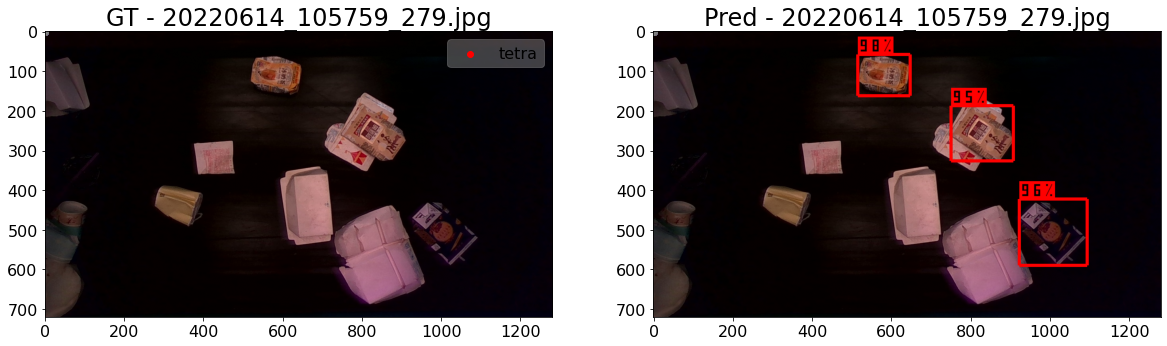

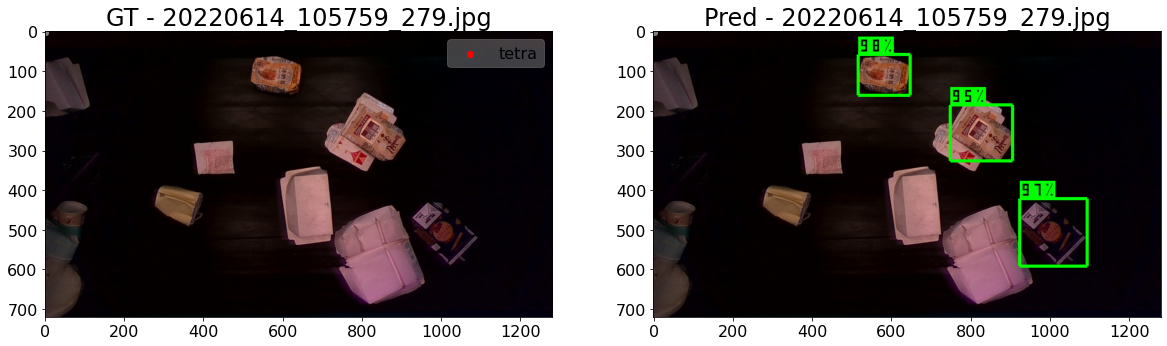

--------------------
self.D[list(self.D)[0]]['match'] = [(0, 0), (1, 1), (2, 2)]
acqL.min()=-1.0, acqL.max()=3.0950088393458355,
acqL.mean()=0.029731093211354614, acqL.std()=0.46957966789685607
----------acq----------


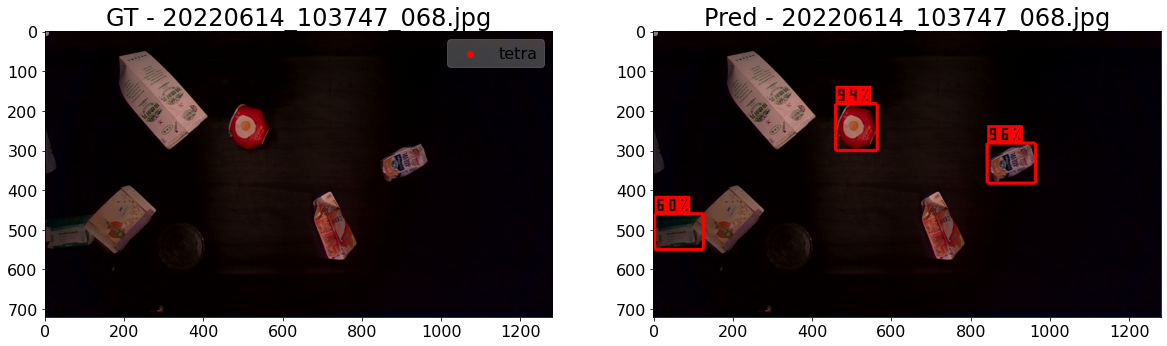

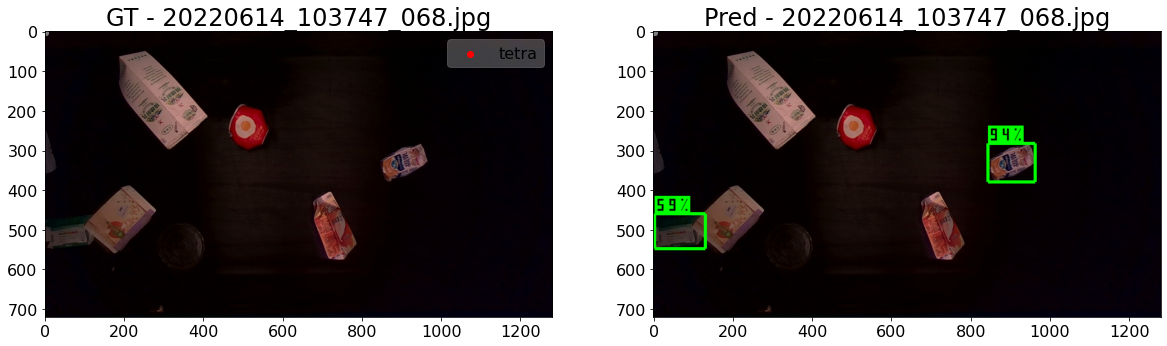

--------------------
----------hard----------


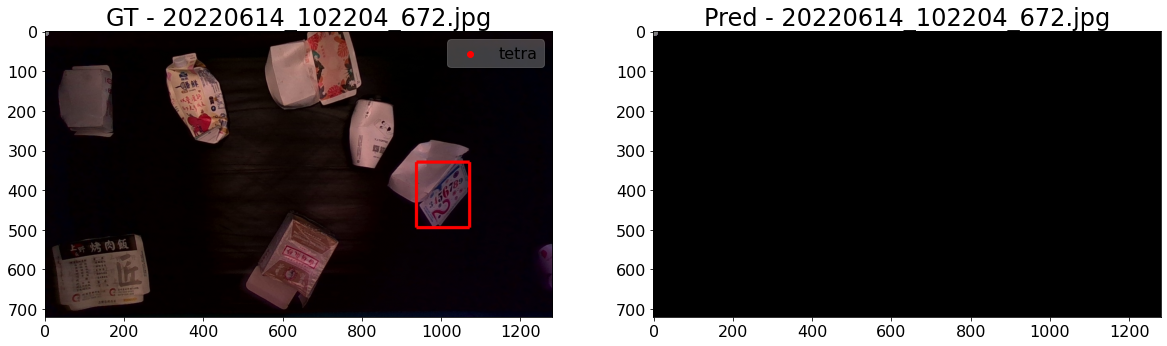

--------------------
----------easy----------


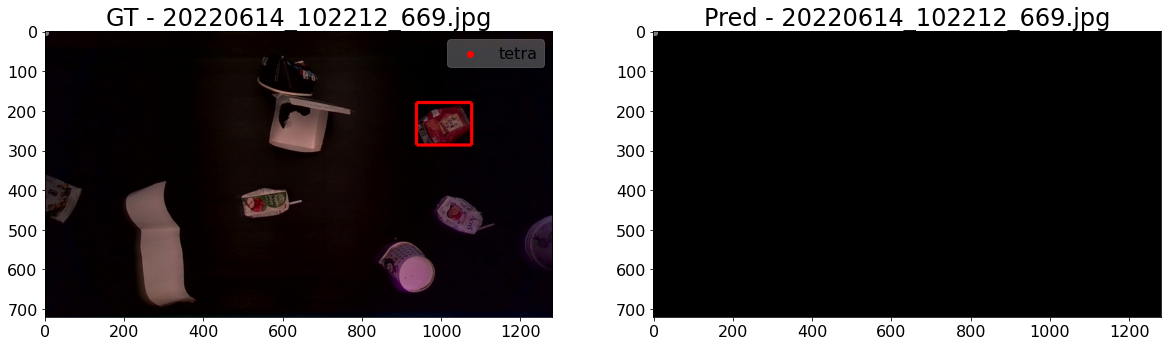

--------------------


In [87]:
obj = ActiveLearning("/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14", "../runs/test/unlabeled0614_v0_raw/best_1365_predictions.json", \
                     "../runs/test/unlabeled0614_v0_flip/best_1365_predictions.json", 0.08, ['tetra'], "../_data/psuedoV0")
obj.visPredict("random")
obj.matching()
obj.score()
obj.visPredict("acq")
obj.generate()
obj.visPseudo("hard")
obj.visPseudo("easy")

self.height=720, self.width=1280, len(self.D)=3145
self.D[list(self.D)[0]] = {'r': [[0, 0.98291, 517.0, 62.0, 648.0, 163.5], [0, 0.96729, 923.0, 421.5, 1093.0, 591.5], [0, 0.94043, 748.5, 185.0, 908.5, 329.0], [0, 0.00138, 0.0, 706.0, 81.5, 720.0]], 'f': [[0, 0.96777, 515.5, 62.25, 649.5, 160.75], [0, 0.94922, 749.5, 185.25, 909.0, 329.25], [0, 0.9458, 923.75, 420.75, 1094.25, 592.5], [0, 0.00107, 861.5, 361.25, 1179.375, 681.0]]}
----------random----------


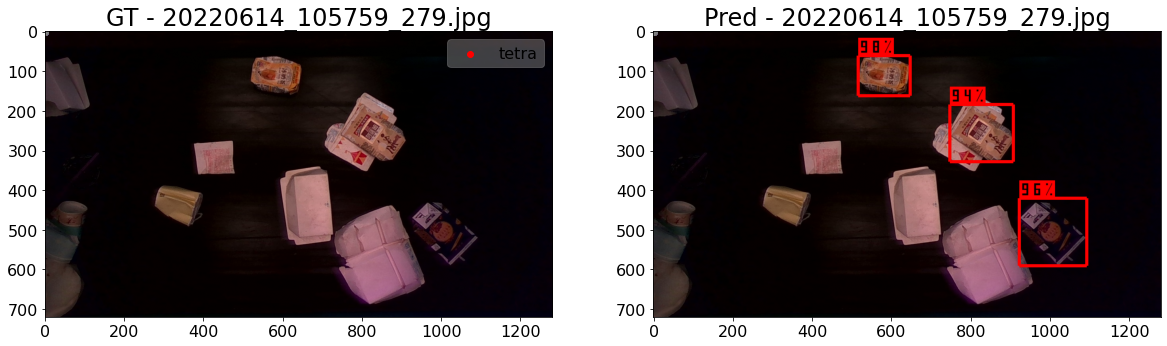

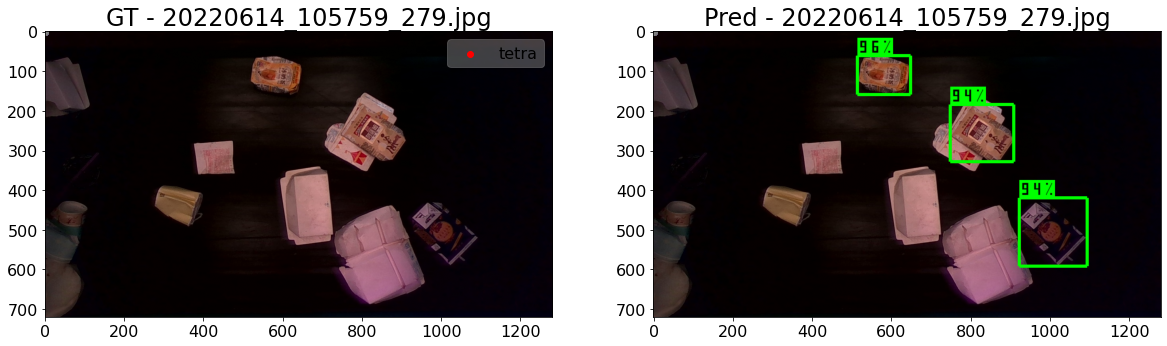

--------------------
self.D[list(self.D)[0]]['match'] = [(0, 0), (1, 2), (2, 1), (3, 4)]
acqL.min()=-1.0, acqL.max()=2.7662952207625042,
acqL.mean()=0.07584385196599627, acqL.std()=0.46972015913382603
----------acq----------


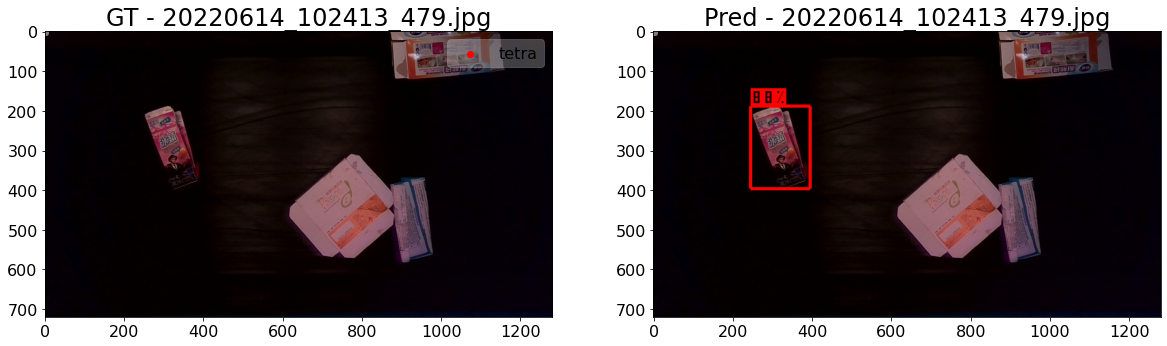

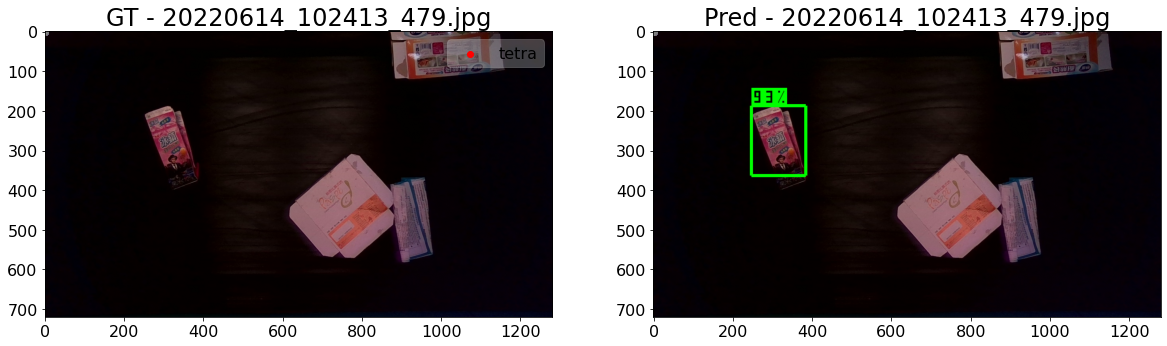

--------------------
len(os.listdir(self.outputPath+'/hard'))=101
len(os.listdir(self.outputPath+'/easy'))=17
----------hard----------


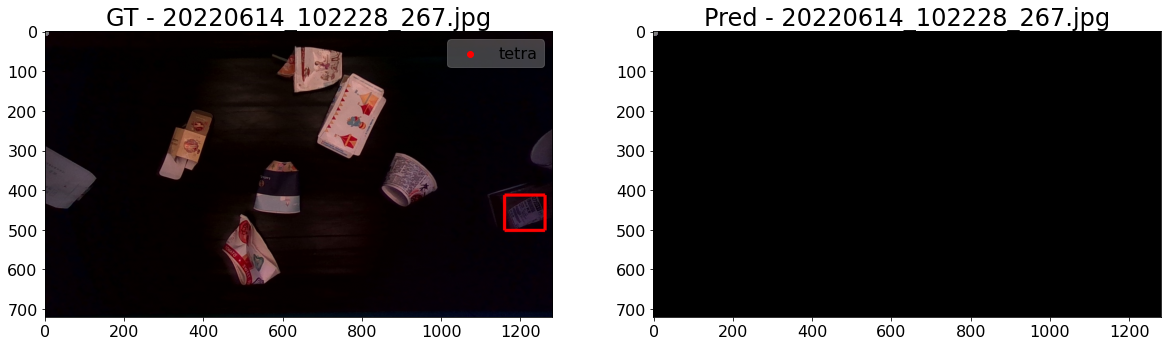

--------------------
----------easy----------


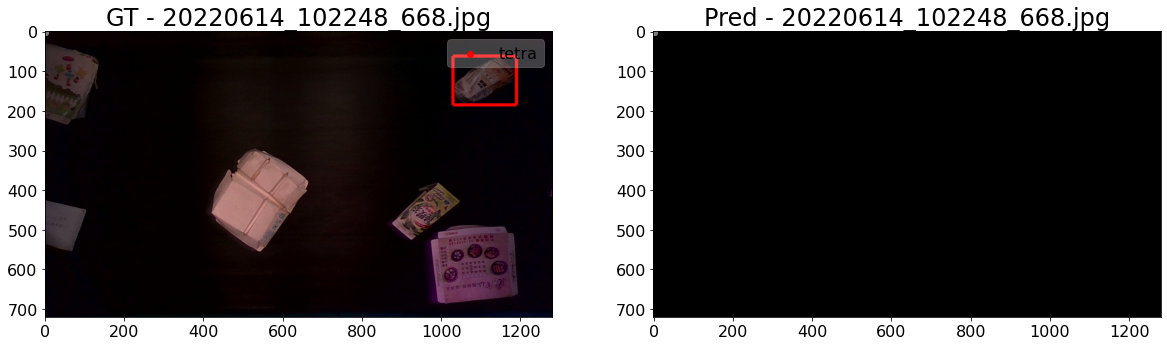

--------------------


In [88]:
obj = ActiveLearning("/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14", "../runs/test/unlabeled0614_v4v0_raw/best_504_predictions.json", \
                     "../runs/test/unlabeled0614_v4v0_flip/best_504_predictions.json", 0.73, ['tetra'], "../_data/sampleV4_psuedoV0")
obj.visPredict("random")
obj.matching()
obj.score()
obj.visPredict("acq")
obj.generate()
obj.visPseudo("hard")
obj.visPseudo("easy")

self.height=720, self.width=1280, len(self.D)=3145
self.D[list(self.D)[0]] = {'r': [[0, 0.9502, 748.5, 187.5, 910.5, 328.5], [0, 0.94922, 516.5, 60.125, 648.5, 160.125], [0, 0.94824, 922.5, 422.0, 1096.0, 591.0], [0, 0.00163, 758.5, 169.0, 827.5, 219.0], [0, 0.00152, 745.5, 258.25, 832.5, 344.75]], 'f': [[0, 0.96094, 517.5, 61.0, 649.5, 162.5], [0, 0.95117, 749.5, 186.0, 910.5, 328.5], [0, 0.94434, 923.0, 423.0, 1093.5, 592.0], [0, 0.00304, 750.5, 179.25, 849.5, 280.75]]}
----------random----------


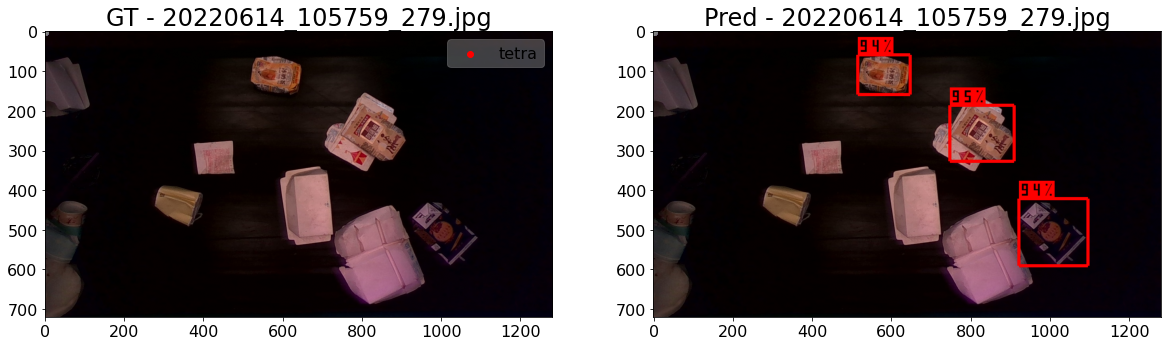

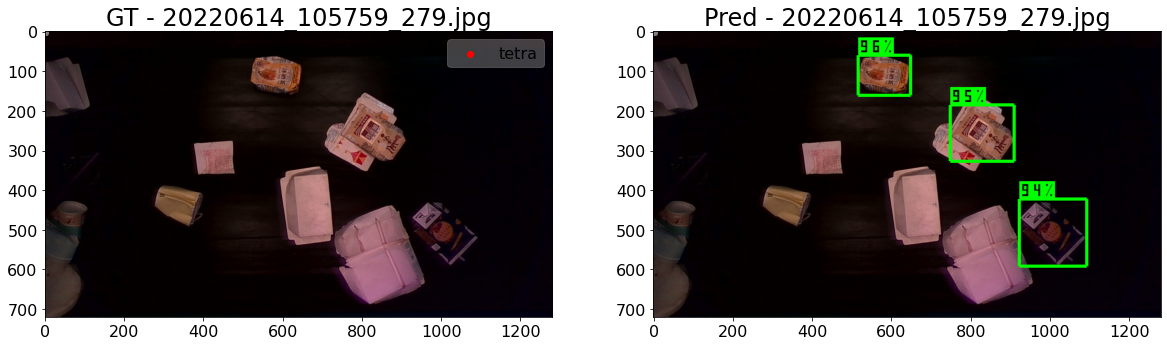

--------------------
self.D[list(self.D)[0]]['match'] = [(0, 1), (1, 0), (2, 2), (3, 4), (4, 5)]
acqL.min()=-1.0, acqL.max()=3.233277827694455,
acqL.mean()=-0.07560106028853629, acqL.std()=0.490410987887015
----------acq----------


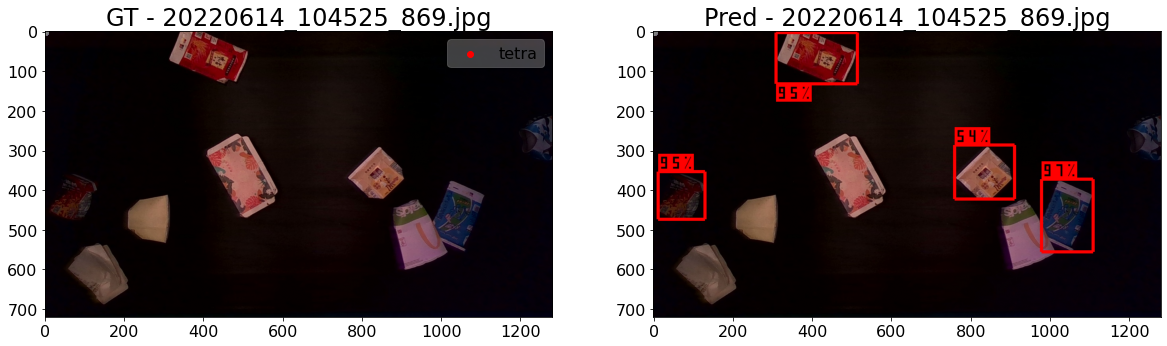

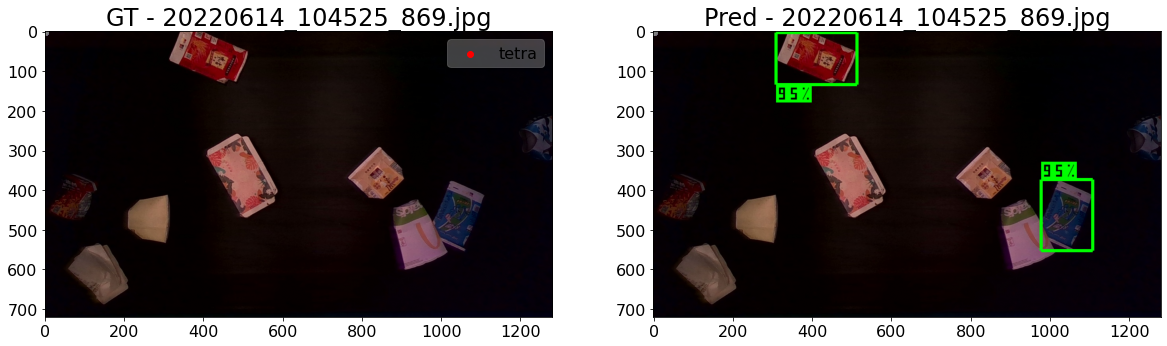

--------------------
len(os.listdir(self.outputPath+'/hard'))=101
len(os.listdir(self.outputPath+'/easy'))=5
----------hard----------


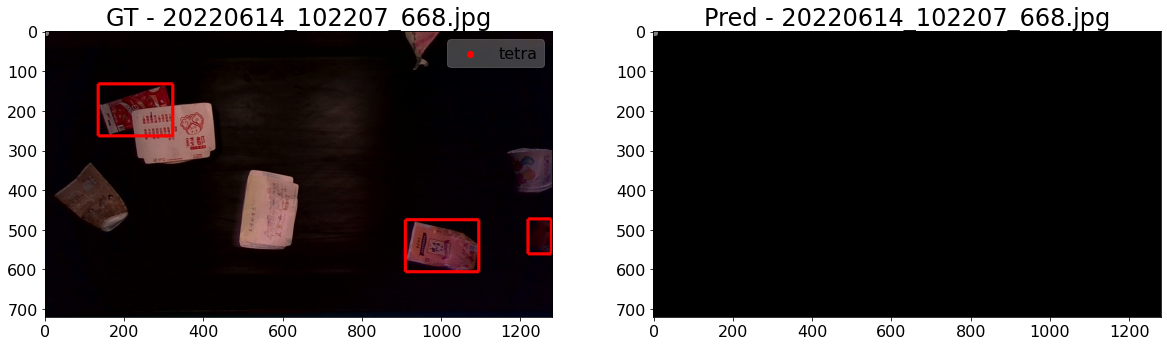

--------------------
----------easy----------


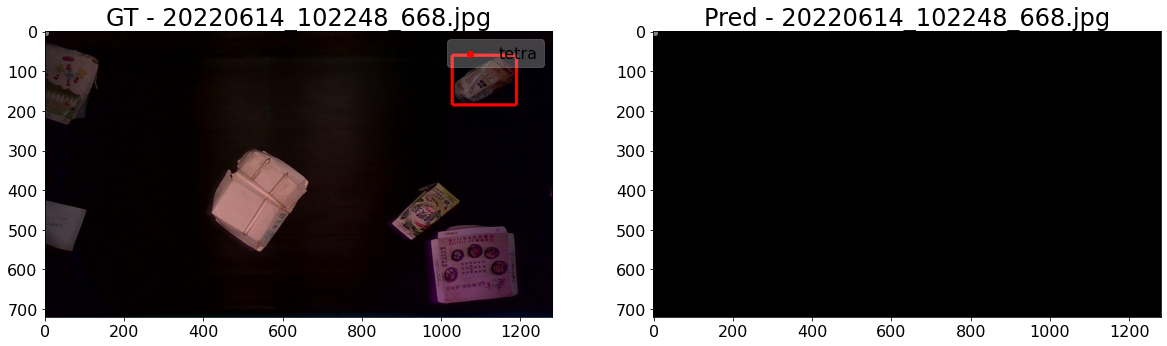

--------------------


In [90]:
obj = ActiveLearning("/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14", "../runs/test/unlabeled0614_v4v1_raw/best_535_predictions.json", \
                     "../runs/test/unlabeled0614_v4v1_flip/best_535_predictions.json", 0.48, ['tetra'], "../_data/sampleV4_pseudoV1")
obj.visPredict("random")
obj.matching()
obj.score()
obj.visPredict("acq")
obj.generate()
obj.visPseudo("hard")
obj.visPseudo("easy")

self.height=720, self.width=1280, len(self.D)=3145
self.D[list(self.D)[0]] = {'r': [[0, 0.9707, 517.5, 61.688, 648.5, 161.75], [0, 0.94531, 924.5, 418.0, 1094.0, 592.0], [0, 0.92871, 747.5, 186.25, 910.5, 329.25], [0, 0.01006, 707.0, 239.0, 807.0, 343.5], [0, 0.0044, 702.0, 230.25, 767.0, 320.25], [0, 0.00218, 1016.0, 508.5, 1096.0, 588.5], [0, 0.00123, 869.0, 361.25, 1169.0, 677.0], [0, 0.00112, 717.5, 227.625, 757.5, 258.5]], 'f': [[0, 0.96191, 517.5, 62.188, 649.5, 161.5], [0, 0.95361, 748.5, 185.0, 908.75, 327.0], [0, 0.94873, 925.0, 419.5, 1092.0, 593.5], [0, 0.0099, 716.0, 258.75, 828.0, 351.25], [0, 0.00196, 702.5, 226.0, 755.5, 306.0], [0, 0.00172, 715.5, 228.0, 759.5, 265.5], [0, 0.00158, 322.0, 0.0, 427.0, 5.188], [0, 0.00101, 861.0, 358.25, 1172.125, 680.0]]}
----------random----------


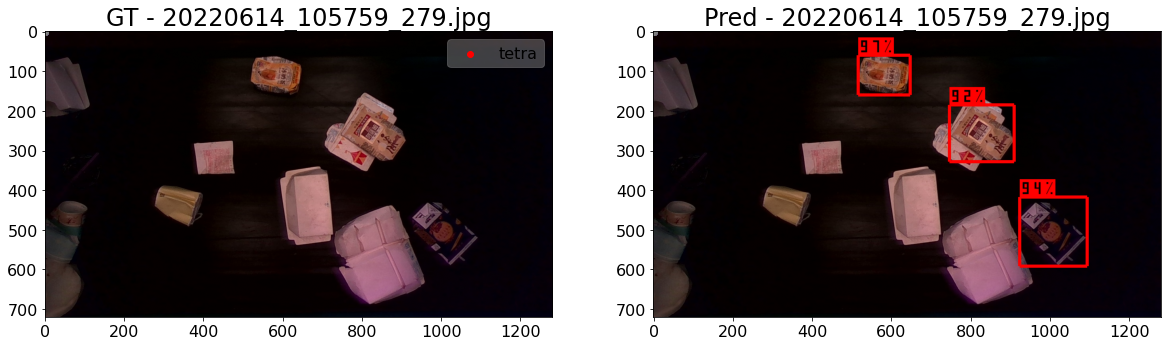

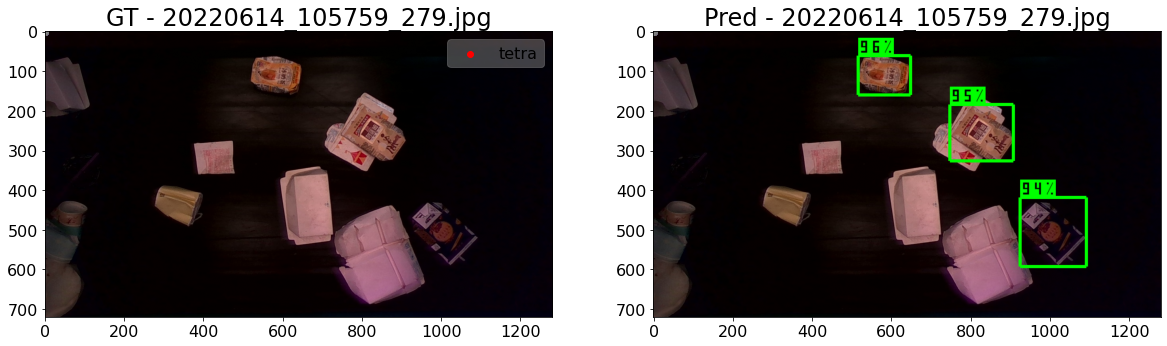

--------------------
self.D[list(self.D)[0]]['match'] = [(0, 0), (1, 2), (2, 1), (3, 8), (4, 9), (5, 10), (6, 7), (7, 11)]
acqL.min()=-1.0, acqL.max()=2.5496193563910103,
acqL.mean()=0.02185249613460755, acqL.std()=0.3416775399058915
----------acq----------


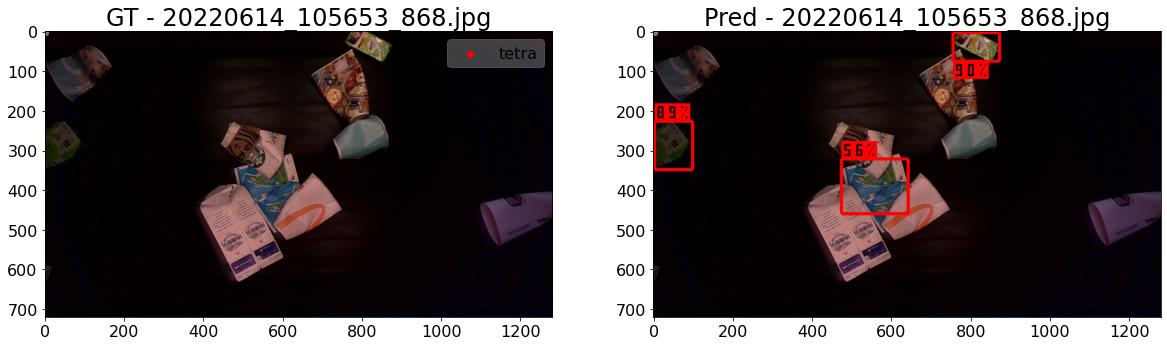

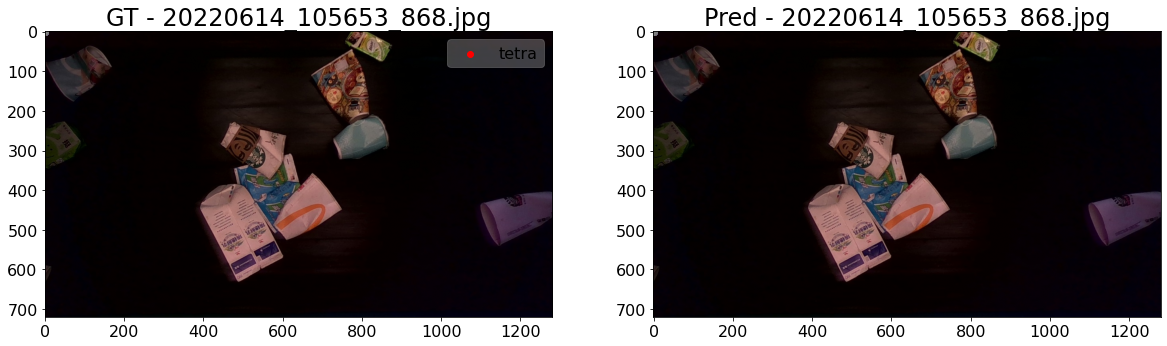

--------------------
len(os.listdir(self.outputPath+'/hard'))=101
len(os.listdir(self.outputPath+'/easy'))=13
----------hard----------


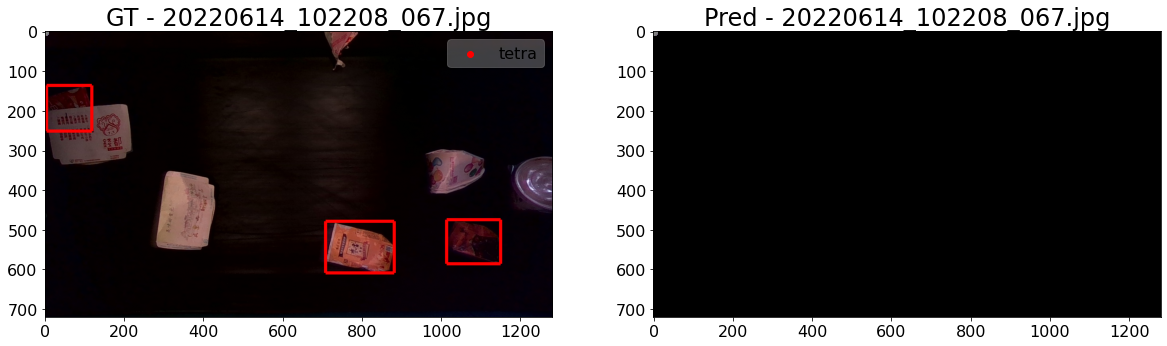

--------------------
----------easy----------


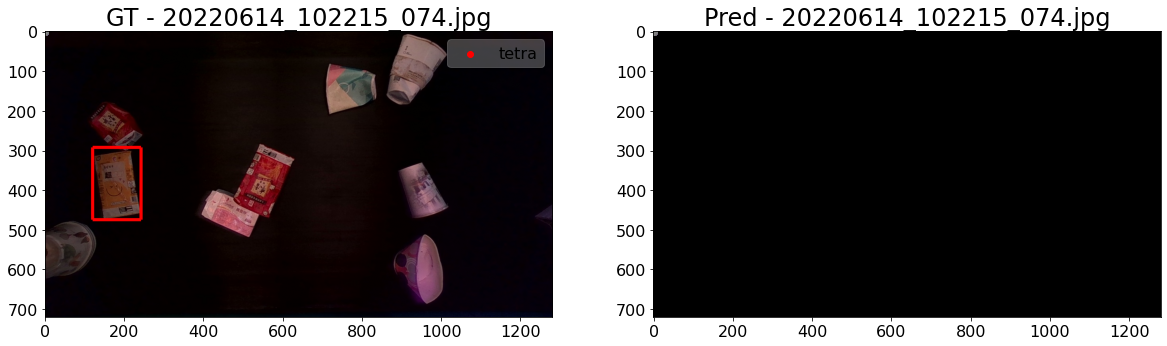

--------------------


In [91]:
obj = ActiveLearning("/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14", "../runs/test/unlabeled0614_v4v2_raw/best_424_predictions.json", \
                     "../runs/test/unlabeled0614_v4v2_flip/best_424_predictions.json", 0.51, ['tetra'], "../_data/sampleV4_pseudoV2")
obj.visPredict("random")
obj.matching()
obj.score()
obj.visPredict("acq")
obj.generate()
obj.visPseudo("hard")
obj.visPseudo("easy")

In [98]:
def countHighest(self, topN=50):
    confL = []
    for key in self.D.keys():
        if self.D[key]['r']:
            confL += list( np.array(self.D[key]['r'])[:,1] )
    confL = sorted(confL, reverse=True)
    print( confL[topN] )
    return confL[topN]

countHighest(obj)

0.98193


0.98193